# Diffusion-decay ingrowth model

This script shows how to set up a diffusion-decay-ingrowth model in UWDiffusion in a zircon mesh geometry. It shows how to update the diffusivity of the parent and daughter isotopes during the model run if the temperature changes. It also shows how to model two different zircon growth events.

------

First we import the required modules

In [1]:
import os
import time

In [2]:
os.environ["UW_TIMING_ENABLE"] = "1"
from underworld3 import timing

In [3]:
import underworld3 as uw
import UWDiffusion as DIF

import h5py

In [4]:
import numpy as np
import sympy as sp
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

------
We include the timing in this script to see how the model performs

In [5]:
timing.reset()
timing.start()
time_start = time.time()

------
Here we setup some parameters for the model for the unknown and discretisation of the domain.

These can either be modified in the script or specified in the command line, e.g. 
`python3 zircon-U-Pb-dual_grwith-example.py -uw_csize 0.01` 
to modify the cell cize to 0.01

In [6]:
U_degree    = uw.options.getInt("U_degree", default=2)
continuous  = uw.options.getBool("continuous", default=True)

csize       = uw.options.getReal("csize", default=0.05)

tolerance   = uw.options.getReal("tolerance", default=1e-6)


save_figs    = uw.options.getBool("save_figs", default=True)

CFL_fac      = uw.options.getReal("CFL_fac", default=0.5)

# dt_max = uw.options.getInt("dt_max", default=1) ### Myr

if uw.mpi.rank == 0:
    print(f'csize = {csize}, CFL = {CFL_fac}, degree = {U_degree},')

csize = 0.05, CFL = 0.5, degree = 2,


------
Here we setup some parameters of the model to test against the benchmark. Modifying these parameters will automatically update the analytical solution.

In [7]:

T_initial = uw.options.getReal(name='temp_initial', default = 800)  # Starting temperature
T_pulse   = uw.options.getReal(name='temp_pulse', default = 800)  # peak temperature of pulse
T_base    = uw.options.getReal(name='temp_base', default = 750)    # Final asymptotic temperature


t_start = uw.options.getReal("time_start", default=0) ### Myr ( 1 - Ma, i.e. model start time)
t_end   = uw.options.getReal("time_end", default=1500) ### Myr ( 1 - Ma, i.e. model end time)

t_pulse = uw.options.getReal(name='pulse_time', default = 1000) ### Myr, time after model start time (also the 2nd growth time)


duration = (t_end - t_start)


outputPath  = uw.options.getString('outputPath', default= f'./output/Diffusion-Decay-ingrowth-dual_growth_duration={int(duration)}_2nd_growth={int(t_pulse)}Myr_pulseT{T_pulse}C_csize={csize}_new/')


if uw.mpi.rank == 0:
    os.makedirs(outputPath, exist_ok=True)




In [8]:
# Symbolic variable
t = sp.symbols('t')

# Gaussian function
def gaussian(T0, T_base, t0, t_pulse, std, t_sym):
    return T_base + (T0 - T_base) * sp.exp(-((t_sym - t0) ** 2) / (2 * std ** 2))

# Piecewise temperature profile
T = sp.Piecewise(
    (gaussian(T_initial, T_base, t_start, t_pulse, 40, t), t < 500),
    (gaussian(T_pulse, T_base, t_pulse, t_pulse, 120, t), t >= 500)
)

# Assume T is your sympy Piecewise function and t is the symbol
T_func = sp.lambdify(t, T, modules='numpy')




#### alternatively the T and t points can be provied, which can be used to create the temperature_interp function

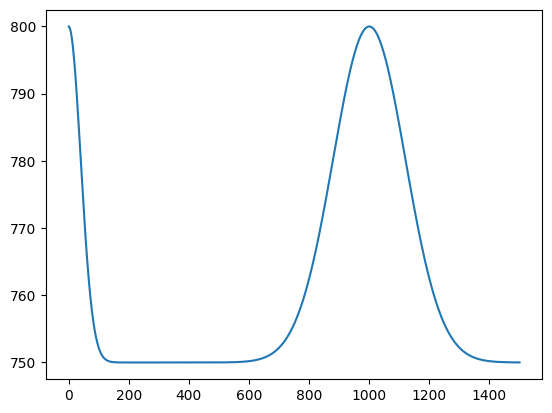

In [9]:
time_profile = np.linspace(t_start, t_end, int(t_end) ) ### every 1 Myr
temp_profile = T_func(time_profile)

# Create the interpolator
temperature_interp = interp1d(
    time_profile, 
    temp_profile,
    kind='linear', 
    fill_value='extrapolate' 
)

if uw.is_notebook:
    plt.plot(time_profile, temp_profile)

#### The diffusion coefficient (D)
------
Here we outline the variables to determine the diffusion coefficient for U and Pb. We use sympy to generate a symbolic equation and substitute the values in.

------


Table of variables to determine the diffusion coefficient for each element
| Variable | Symbol            | units | U | Pb | 
| :---------- | :-------: | :-------: | :------: |  ------: | 
| Pre-exponent| $D_0$   | $\text{m}^2\, \text{s}^{-1}$ |  1.63   | 0.11 |
| Activation energy | $E_a$  | $\text{kJ}\, \text{mol}^{-1}$ |  726 $\pm$ 83    |  550 $\pm$ 30  |
| Gas constant | $R$  | $\text{J}\, \text{mol}^{-1}\, \text{K}^{-1}$ |  8.314    | 8.314 | 
| Reference | |  | [Cherniak and Watson, 1997](http://link.springer.com/10.1007/s004100050287) | [Cherniak and Watson, 2001](https://www.sciencedirect.com/science/article/pii/S0009254100002333) | [Cherniak and Watson, 2007](https://www.sciencedirect.com/science/article/pii/S0009254107002148) | 

##### we make the symbolic form into equations for both U and Pb by substituting in the required values

In [10]:
D, E, R, T = sp.symbols('D E R T') # Temperature in Kelvin

D_sym = D * sp.exp(-E / (R * (T+ 273.15) ) )

In [11]:
def diffusivity_fn(D_sym, D0, Ea):
    D_exp = D_sym.subs({D: D0, E: Ea, R: 8.314}).simplify()
    return sp.lambdify(T, D_exp, 'numpy')

D_Pb_fn = diffusivity_fn(D_sym, D0=0.11, Ea=550e3)
D_U_fn = diffusivity_fn(D_sym, D0=10**0.212, Ea=726e3)

#### Here we calculate the initial U-238 and U-235 amounts at the model start time based on their current abudance

This could be modified for any parent-daughter isotope system

In [12]:
import sympy as sp

# Symbolic variable for elapsed time (years)
t = sp.Symbol('t')

# Constants: half-lives in years
half_life_U235 = 703.8e6
half_life_U238 = 4.468e9

# Decay constants (yr^-1)
lambda_U235 = sp.log(2) / half_life_U235
lambda_U238 = sp.log(2) / half_life_U238

# Present-day U-238/U-235 ratio (dimensionless)
current_ratio_U238_to_U235 = 137.818

# Abundance at time t (years ago), normalized so present-day U-235 = 1
U235_fn = sp.Lambda(t, sp.exp(lambda_U235 * t))
U238_fn = sp.Lambda(t, current_ratio_U238_to_U235 * sp.exp(lambda_U238 * t))
ratio_fn = sp.Lambda(t, U238_fn(t) / U235_fn(t))

U235_amount = float(U235_fn(t_end * 1e6))
U238_amount = float(U238_fn(t_end * 1e6))
U238_U235_ratio = float(ratio_fn(t_end * 1e6))

if uw.mpi.rank == 0:
    print(f"U-235 abundance at {(t_end):1f} Ma: {U235_amount:.4f}")
    print(f"U-238 abundance at {(t_end):1f} Ma: {U238_amount:.4f}")
    print(f"U-238/U-235 ratio at {(t_end):1f} Ma: {U238_U235_ratio:.2f}")

U-235 abundance at 1500.000000 Ma: 4.3811
U-238 abundance at 1500.000000 Ma: 173.9274
U-238/U-235 ratio at 1500.000000 Ma: 39.70


#### Scaling the model
------
Numerical models are easier to solve when non-dimensionalised. Here we use pint to set some scaling coefficients that can be used to non-dimensionalise values used in the model.

In [13]:
# import unit registry
u = uw.scaling.units

### make scaling easier
ndim, nd = uw.scaling.non_dimensionalise, uw.scaling.non_dimensionalise
dim  = uw.scaling.dimensionalise 


diffusive_rate    = D_Pb_fn(T_initial) * u.meter**2 /u.second
model_length      = 100 * u.micrometer ### scale the mesh radius to the zircon radius


KL = model_length
Kt = model_length**2 / diffusive_rate


scaling_coefficients  = uw.scaling.get_coefficients()
scaling_coefficients["[length]"] = KL
scaling_coefficients["[time]"] = Kt

scaling_coefficients


# ### Create analytical fn

[mass],1.0 kilogram
[length],9.999999999999999e-05 meter
[temperature],1.0 kelvin
[time],5.37457791566322e+19 second
[substance],1.0 mole


#### Here we manually setup the inner and outer zircon for dual growth
We provide the points of which the mesh is constructed

In [14]:
# Points coordinates of mesh

from enum import Enum

class boundaries_2D(Enum):
    outerBoundary0 = 21
    outerBoundary1 = 22
    outerBoundary2 = 23
    outerBoundary3 = 24
    outerBoundary4 = 25
    outerBoundary5 = 26
    outerBoundary6 = 27
    outerBoundary7 = 28
    innerBoundary0 = 31
    innerBoundary1 = 32
    innerBoundary2 = 33
    innerBoundary3 = 34
    innerBoundary4 = 35
    innerBoundary5 = 36
    innerBoundary6 = 37
    innerBoundary7 = 38

### width (x) = 0.6 (60 micron), height (y) = 1. (100 micron)

points0 = [(-0.3, 0.35, 0), (-0.2, 0.5, 0), (0.2, 0.5, 0), (0.3, 0.35, 0), 
        (0.3, -0.35, 0), (0.2, -0.5, 0), (-0.2, -0.5, 0), (-0.3,-0.35, 0)]

inner_zircon = np.array(points0)


points1 = [(-0.6, 0.35, 0), (-0.2, 0.9, 0), (0.2, 0.9, 0), (0.6, 0.35, 0), 
        (0.6, -0.35, 0), (0.2, -0.9, 0), (-0.2, -0.9, 0), (-0.6,-0.35, 0)]

outer_zircon = np.array(points1)

In [15]:
if uw.mpi.rank == 0:
    import gmsh
    gmsh.initialize()
    gmsh.option.setNumber("General.Verbosity", 0)
    gmsh.model.add("BoxInsideBox")

    cellSize = csize

    outer_points = outer_zircon
    outer_point_ids = [gmsh.model.geo.addPoint(x, y, z, cellSize) for x, y, z in outer_points]

    # Define the corner points of the inner box
    inner_points = inner_zircon
    inner_point_ids = [gmsh.model.geo.addPoint(x, y, z, cellSize) for x, y, z in inner_points]

    # Define the lines connecting the points of the outer box
    outer_line_ids = [gmsh.model.geo.addLine(outer_point_ids[i], outer_point_ids[(i + 1) % len(outer_point_ids)]) for i in range(len(outer_point_ids))]

    # Define the lines connecting the points of the inner box
    inner_line_ids = [gmsh.model.geo.addLine(inner_point_ids[i], inner_point_ids[(i + 1) % len(inner_point_ids)]) for i in range(len(inner_point_ids))]

    # Create line loops for the inner box and the outer box
    inner_loop = gmsh.model.geo.addCurveLoop(inner_line_ids)
    outer_loop = gmsh.model.geo.addCurveLoop(outer_line_ids)

    # Create plane surfaces for the inner box and the outer box
    inner_surface = gmsh.model.geo.addPlaneSurface([inner_loop])
    outer_surface = gmsh.model.geo.addPlaneSurface([outer_loop, inner_loop])

    gmsh.model.geo.synchronize()

    # Add physical groups for the boundaries
    for i, line_id in enumerate(inner_line_ids):
        boundary_tag = getattr(boundaries_2D, f"innerBoundary{i}")
        gmsh.model.addPhysicalGroup(1, [line_id], tag=boundary_tag.value, name=boundary_tag.name)

    for i, line_id in enumerate(outer_line_ids):
        boundary_tag = getattr(boundaries_2D, f"outerBoundary{i}")
        gmsh.model.addPhysicalGroup(1, [line_id], tag=boundary_tag.value, name=boundary_tag.name)

    # gmsh.model.addPhysicalGroup(1, inner_line_ids, tag=boundaries_2D.innerBoundary.value)
    # gmsh.model.setPhysicalName(1, 5, boundaries_2D.innerBoundary.name)

    # gmsh.model.addPhysicalGroup(1, outer_line_ids, tag=boundaries_2D.outerBoundary.value)
    # gmsh.model.setPhysicalName(1, 5, boundaries_2D.outerBoundary.name)

    # Add physical groups for the surfaces
    gmsh.model.addPhysicalGroup(2, [outer_surface], tag=7)
    gmsh.model.setPhysicalName(2, 6, 'outer_surface')

    gmsh.model.addPhysicalGroup(2, [inner_surface], tag=8)
    gmsh.model.setPhysicalName(2, 7, 'inner_surface')

    # Add physical group for the surface
    gmsh.model.addPhysicalGroup(2, [outer_surface], 99999)
    gmsh.model.setPhysicalName(2, 99999, "Elements")


    # Generate a 2D mesh
    gmsh.model.mesh.generate(2)

    # Save the mesh to a file
    # outputPath = "./meshes"
    gmsh.write(f'{outputPath}/dual_zircon_mesh_csize={csize}.msh')

    # Finalize the Gmsh session
    gmsh.finalize()

    # Print a message to indicate that the script has finished
    print("Mesh generation complete.", flush=True)

Mesh generation complete.


In [16]:
zircon_mesh = uw.discretisation.Mesh(
        f'{outputPath}/dual_zircon_mesh_csize={csize}.msh',
        degree=1,
        qdegree=U_degree,
        boundaries=boundaries_2D,
        boundary_normals=None,
        coordinate_system_type=uw.coordinates.CoordinateSystemType.CARTESIAN,
        useMultipleTags=True,
        useRegions=True,
        markVertices=True,
        refinement=None,
        refinement_callback=None,
    )

#### we use a mesh variable to determine if the area is either part of the first or second growth, which is used for updating the U isotope values

In [17]:

zircon_regions  = uw.discretisation.MeshVariable("zircon_regions", zircon_mesh, 1, degree=U_degree)

In [18]:
### Label the inner and outer zircon regions
from matplotlib.patches import Circle, Polygon, Wedge
internal_zircon_polygon = Polygon(inner_zircon[:,0:2], closed=True)

with zircon_mesh.access(zircon_regions):
    zircon_regions.data[:,0] = internal_zircon_polygon.contains_points(zircon_regions.coords, radius=1e-8)

------
Here is where the diffusion-decay-ingrowth model is set up. The parent and daughter isotope names are provided, along with the parent isotope half life and initial amount. 

-----

In [19]:
U238_Pb206 = DIF.DiffusionDecayIngrowthModel(
        parent_name=r"{}^{238}\text{U}", daughter_name=r"{}^{206}\text{Pb}", half_life=half_life_U238*u.year, mesh=zircon_mesh
    )

U235_Pb207 = DIF.DiffusionDecayIngrowthModel (
        parent_name=r"{}^{235}\text{U}", daughter_name=r"{}^{207}\text{Pb}", half_life=half_life_U235*u.year, mesh=zircon_mesh
    )

In [20]:
with U238_Pb206.mesh.access(U238_Pb206.parent_mesh_var, U238_Pb206.daughter_mesh_var):
    ### inside is the initial amount, outside is 0
    U238_Pb206.parent_mesh_var.data[(zircon_regions.data[:,0] == 1)] = U238_amount
    U238_Pb206.parent_mesh_var.data[(zircon_regions.data[:,0] == 0)] = 0.
    #### the initial Pb206 is 0 everywhere
    U238_Pb206.daughter_mesh_var.data[:, 0] = 0.0

U238_Pb206.init_model()

In [21]:
with U235_Pb207.mesh.access(U235_Pb207.parent_mesh_var, U235_Pb207.daughter_mesh_var):
    ### inside is the initial amount, outside is 0
    U235_Pb207.parent_mesh_var.data[(zircon_regions.data[:,0] == 1)] = U235_amount
    U235_Pb207.parent_mesh_var.data[(zircon_regions.data[:,0] == 0)] = 0.
    #### the initial Pb207 is 0 everywhere
    U235_Pb207.daughter_mesh_var.data[:, 0] = 0.0

U235_Pb207.init_model()

------
The diffusivity of both the parent and daughter isotopes need  to be set for each model. This is done through either the _*.parent_diffusivity_ or _*.daughter_diffusivity_ parameters.


-----

In [22]:
T_initial = temperature_interp(0)

Pb_kappa = (D_Pb_fn(T_initial) * u.meter**2 / u.second)
U_kappa = (D_U_fn(T_initial) * u.meter**2 / u.second)

In [23]:
U238_Pb206.parent_diffusivity = D_U_fn(T_initial) * u.meter**2 / u.second

U238_Pb206.daughter_diffusivity = D_Pb_fn(T_initial) * u.meter**2 / u.second

In [24]:
U235_Pb207.parent_diffusivity = D_U_fn(T_initial) * u.meter**2 / u.second

U235_Pb207.daughter_diffusivity = D_Pb_fn(T_initial) * u.meter**2 / u.second

##### This is how the boundary condition at the edge of the mesh, with 0 concentration used in this example for both the parent and daughter isotopes.

In [25]:
BC_value = sp.Float(0)

### Pb and U boundaries set to 0
for _solver in [U235_Pb207.parent_diffusion, U235_Pb207.daughter_diffusion, U238_Pb206.parent_diffusion, U238_Pb206.daughter_diffusion]:
    ### reapply outer boundary condition
    for _boundary in _solver.mesh.boundaries:
        if 'outerBoundary' in _boundary.name:
            _solver.add_dirichlet_bc([BC_value], _boundary.name)
        if 'innerBoundary' in _boundary.name:
            _solver.add_dirichlet_bc([BC_value], _boundary.name)


    _solver.petsc_options["snes_rtol"]   = tolerance*1e-4
    _solver.petsc_options["snes_atol"]   = tolerance
    _solver.petsc_options["ksp_atol"]    = tolerance
    _solver.petsc_options["snes_max_it"] = 100
    _solver.petsc_options["snes_monitor_short"] = None 

#####  We can use underworld3 to save the parent and daughter initial isotope values

In [26]:

zircon_mesh.petsc_save_checkpoint(meshVars=[U238_Pb206.parent_mesh_var, 
                                            U238_Pb206.daughter_mesh_var, 
                                            U235_Pb207.parent_mesh_var, 
                                            U235_Pb207.daughter_mesh_var], 
                                            index=0, 
                                            outputPath=outputPath)

------
We setup a function to update the diffusivity (kappa) as the model is running. This is to capture changes in diffusivity as the temperature varies

-----

In [27]:
def update_kappa(Model, D_p_fn, D_d_fn, temperature_interp):
    current_temp = temperature_interp(dim(Model.current_time, u.megayear).m) #T_start - gradient*dim(Model.current_time, u.megayear).m
    kappa_p = D_p_fn(current_temp)
    kappa_d = D_d_fn(current_temp)
    Model.parent_diffusivity = kappa_p * u.meter**2 / u.second
    Model.daughter_diffusivity = kappa_d * u.meter**2 / u.second





In [28]:
def update_kappa_wrapper():
    update_kappa(U238_Pb206, D_U_fn, D_Pb_fn, temperature_interp)


U238_Pb206.register_pre_solve_hook('update kappa routine', update_kappa_wrapper)

------
Due to the diffusivity changing with temperature, we need to constrain how large we'd like timesteps to be.

Here we set a maximum allowed $\Delta$T to determine the largest timestep permitted (max_dt).

We can also set a minimum timestep (min_dt), as the timesteps will become expoentially small as temperature increases

-----

In [29]:
dTdt = np.diff(temp_profile) / np.diff(time_profile)
max_allowed_temp_change = 5 ### C
dt_temp_change = np.min(max_allowed_temp_change / np.maximum(np.abs(dTdt), 1e-12))

min_dt = 0.1 ### Myr

#### Now we run the the U238 --> Pb206 model up until the second growth event

In [30]:
U238_Pb206.run_simulation(duration=t_pulse*u.megayear, min_dt=min_dt*u.megayear, max_dt=dt_temp_change*u.megayear, diffusion_time_step_factor=CFL_fac)


Step 0, dt: 6.596161580004554 Myr,  Time: 0.00 Myr
  0 SNES Function norm 875.176
  1 SNES Function norm 0.00962135
  2 SNES Function norm 5.4705e-05
  0 SNES Function norm 854810.
  1 SNES Function norm 9.43432
  2 SNES Function norm 8.94934e-05

Step 1, dt: 6.596161580004554 Myr,  Time: 6.60 Myr
  0 SNES Function norm 1748.47
  1 SNES Function norm 0.0191856
  2 SNES Function norm 5.22761e-05
  0 SNES Function norm 853936.
  1 SNES Function norm 9.42467
  2 SNES Function norm 8.94019e-05

Step 2, dt: 6.596161580004554 Myr,  Time: 13.19 Myr
  0 SNES Function norm 2619.97
  1 SNES Function norm 0.0286854
  2 SNES Function norm 7.8308e-05
  0 SNES Function norm 853062.
  1 SNES Function norm 9.41503
  2 SNES Function norm 8.93104e-05

Step 3, dt: 6.596161580004554 Myr,  Time: 19.79 Myr
  0 SNES Function norm 3489.98
  1 SNES Function norm 0.0381421
  2 SNES Function norm 0.000104208
  0 SNES Function norm 852190.
  1 SNES Function norm 9.4054
  2 SNES Function norm 8.92191e-05

Step 4,

In [31]:
def update_kappa_wrapper():
    update_kappa(U235_Pb207, D_U_fn, D_Pb_fn, temperature_interp)


U235_Pb207.register_pre_solve_hook('update kappa routine', update_kappa_wrapper)

#### And this runs the the U235 --> Pb207 model up until the second growth

In [32]:

U235_Pb207.run_simulation(duration=t_pulse*u.megayear, min_dt=min_dt*u.megayear, max_dt=dt_temp_change*u.megayear, diffusion_time_step_factor=CFL_fac)


Step 0, dt: 6.596161580004554 Myr,  Time: 0.00 Myr
  0 SNES Function norm 139.568
  1 SNES Function norm 0.00153435
  2 SNES Function norm 9.33404e-05
  0 SNES Function norm 21414.4
  1 SNES Function norm 0.236345
  2 SNES Function norm 6.73919e-05

Step 1, dt: 6.596161580004554 Myr,  Time: 6.60 Myr
  0 SNES Function norm 278.074
  1 SNES Function norm 0.00305124
  2 SNES Function norm 7.40558e-05
  0 SNES Function norm 21275.7
  1 SNES Function norm 0.234815
  2 SNES Function norm 6.69555e-05

Step 2, dt: 6.596161580004554 Myr,  Time: 13.19 Myr
  0 SNES Function norm 415.541
  1 SNES Function norm 0.0045496
  2 SNES Function norm 0.000110705
  0 SNES Function norm 21138.
  1 SNES Function norm 0.233294
  2 SNES Function norm 6.6522e-05

Step 3, dt: 6.596161580004554 Myr,  Time: 19.79 Myr
  0 SNES Function norm 552.021
  1 SNES Function norm 0.00603292
  2 SNES Function norm 3.47868e-05
  0 SNES Function norm 21001.1
  1 SNES Function norm 0.231784
  2 SNES Function norm 6.60912e-05



##### Again, underworld3 is sued to save the parent and daughter isotope values just prior to the second growth.

In [33]:

zircon_mesh.petsc_save_checkpoint(meshVars=[U238_Pb206.parent_mesh_var, 
                                            U238_Pb206.daughter_mesh_var, 
                                            U235_Pb207.parent_mesh_var, 
                                            U235_Pb207.daughter_mesh_var], 
                                            index=1, 
                                            outputPath=outputPath)

##### Now we determine the U238 and U235 amount at the second growth stage

In [34]:
U235_amount = float(U235_fn((t_end-t_pulse) * 1e6))
U238_amount = float(U238_fn((t_end-t_pulse) * 1e6))
U238_U235_ratio = float(ratio_fn((t_end-t_pulse) * 1e6))

if uw.mpi.rank == 0:
    print(f"U-235 abundance at {(t_end-t_pulse):1f} Ma: {U235_amount:.4f}")
    print(f"U-238 abundance at {(t_end-t_pulse):1f} Ma: {U238_amount:.4f}")
    print(f"U-238/U-235 ratio at {(t_end-t_pulse):1f} Ma: {U238_U235_ratio:.2f}")

U-235 abundance at 500.000000 Ma: 1.6363
U-238 abundance at 500.000000 Ma: 148.9338
U-238/U-235 ratio at 500.000000 Ma: 91.02


#### And update the mesh variables accordingly for both models

In [35]:
with zircon_mesh.access(U238_Pb206.parent_mesh_var):
    U238_Pb206.parent_mesh_var.data[(zircon_regions.data[:,0] == 0)] = U238_amount

### we have to update the history function after changing the parent concentration
U238_Pb206.parent_diffusion.DuDt.update_history_fn()




In [36]:
with zircon_mesh.access(U235_Pb207.parent_mesh_var):
    U235_Pb207.parent_mesh_var.data[(zircon_regions.data[:,0] == 0)] = U235_amount


### we have to update the history function after changing the parent concentration
U235_Pb207.parent_diffusion.DuDt.update_history_fn()

In [37]:
BC_value = sp.Float(0)

### Pb and U boundaries set to 0
for _solver in [U238_Pb206.parent_diffusion, U238_Pb206.daughter_diffusion]:
    ### reapply outer boundary condition
    _solver._reset()
    for _boundary in _solver.mesh.boundaries:
        if 'outerBoundary' in _boundary.name:
            _solver.add_dirichlet_bc([BC_value], _boundary.name)
        # if 'innerBoundary' in _boundary.name:
        #     _solver.add_dirichlet_bc(BC_value, _boundary.name)

            

In [38]:
for _solver in [U235_Pb207.parent_diffusion, U235_Pb207.daughter_diffusion,]:
    ### reapply outer boundary condition
    _solver._reset()
    for _boundary in _solver.mesh.boundaries:
        if 'outerBoundary' in _boundary.name:
            _solver.add_dirichlet_bc([BC_value], _boundary.name)
        # if 'innerBoundary' in _boundary.name:
        #     _solver.add_dirichlet_bc(BC_value, _boundary.name)




#### Now we run both models until the end model time

In [39]:
U238_Pb206.run_simulation(duration=t_end*u.megayear, min_dt=min_dt*u.megayear, max_dt=dt_temp_change*u.megayear, diffusion_time_step_factor=CFL_fac)


Step 152, dt: 6.596161580004554 Myr,  Time: 1000.00 Myr
  0 SNES Function norm 122088.
  1 SNES Function norm 1.92188
  2 SNES Function norm 9.40506e-05
  0 SNES Function norm 1.2805e+06
  1 SNES Function norm 14.7556
  2 SNES Function norm 0.000100195

Step 153, dt: 6.596161580004554 Myr,  Time: 1006.60 Myr
  0 SNES Function norm 122783.
  1 SNES Function norm 1.91693
  2 SNES Function norm 9.38416e-05
  0 SNES Function norm 1.27919e+06
  1 SNES Function norm 14.7405
  2 SNES Function norm 0.000100093

Step 154, dt: 6.596161580004554 Myr,  Time: 1013.19 Myr
  0 SNES Function norm 123492.
  1 SNES Function norm 1.91213
  2 SNES Function norm 9.36813e-05
  0 SNES Function norm 1.27789e+06
  1 SNES Function norm 14.7254
  2 SNES Function norm 9.99903e-05

Step 155, dt: 6.596161580004554 Myr,  Time: 1019.79 Myr
  0 SNES Function norm 124214.
  1 SNES Function norm 1.90753
  2 SNES Function norm 9.35702e-05
  0 SNES Function norm 1.27658e+06
  1 SNES Function norm 14.7104
  2 SNES Functio

In [40]:
U235_Pb207.run_simulation(duration=t_end*u.megayear, min_dt=min_dt*u.megayear, max_dt=dt_temp_change*u.megayear, diffusion_time_step_factor=CFL_fac)


Step 152, dt: 6.596161580004554 Myr,  Time: 1000.00 Myr
  0 SNES Function norm 13367.5
  1 SNES Function norm 0.210708
  2 SNES Function norm 9.77225e-05
  0 SNES Function norm 13991.7
  1 SNES Function norm 0.16123
  2 SNES Function norm 7.87483e-05

Step 153, dt: 6.596161580004554 Myr,  Time: 1006.60 Myr
  0 SNES Function norm 13412.
  1 SNES Function norm 0.210138
  2 SNES Function norm 9.73904e-05
  0 SNES Function norm 13901.1
  1 SNES Function norm 0.160186
  2 SNES Function norm 7.82384e-05

Step 154, dt: 6.596161580004554 Myr,  Time: 1013.19 Myr
  0 SNES Function norm 13457.2
  1 SNES Function norm 0.209583
  2 SNES Function norm 9.71185e-05
  0 SNES Function norm 13811.1
  1 SNES Function norm 0.159149
  2 SNES Function norm 7.77318e-05

Step 155, dt: 6.596161580004554 Myr,  Time: 1019.79 Myr
  0 SNES Function norm 13502.9
  1 SNES Function norm 0.209048
  2 SNES Function norm 9.69043e-05
  0 SNES Function norm 13721.7
  1 SNES Function norm 0.158119
  2 SNES Function norm 7.

##### Here we use the underworld3 to save the parent and daughter isotope values at the end of the model run

In [41]:

zircon_mesh.petsc_save_checkpoint(meshVars=[U238_Pb206.parent_mesh_var, 
                                            U238_Pb206.daughter_mesh_var, 
                                            U235_Pb207.parent_mesh_var, 
                                            U235_Pb207.daughter_mesh_var], 
                                            index=2, 
                                            outputPath=outputPath)

#### The ratios need to be extracted for the Terra-Wasserburg plot

In [42]:

with U238_Pb206.mesh.access(U238_Pb206.parent_mesh_var, U238_Pb206.daughter_mesh_var):

    ratio_U23Pb8206 = U238_Pb206.parent_mesh_var.data / U238_Pb206.daughter_mesh_var.data

/var/folders/0j/bnxlsh897sl6b1rv06fnt5r80000gp/T/ipykernel_95959/2641801811.py:3: RuntimeWarning: invalid value encountered in divide
  ratio_U23Pb8206 = U238_Pb206.parent_mesh_var.data / U238_Pb206.daughter_mesh_var.data


In [43]:
with U235_Pb207.mesh.access(U235_Pb207.parent_mesh_var, U235_Pb207.daughter_mesh_var):
    ratio_U235_Pb207 = U235_Pb207.parent_mesh_var.data / U235_Pb207.daughter_mesh_var.data

/var/folders/0j/bnxlsh897sl6b1rv06fnt5r80000gp/T/ipykernel_95959/76312694.py:2: RuntimeWarning: invalid value encountered in divide
  ratio_U235_Pb207 = U235_Pb207.parent_mesh_var.data / U235_Pb207.daughter_mesh_var.data


In [44]:
with U235_Pb207.mesh.access(U235_Pb207.daughter_mesh_var), U238_Pb206.mesh.access(U238_Pb206.daughter_mesh_var):
    ratio_Pb207_Pb206 =  U235_Pb207.daughter_mesh_var.data / U238_Pb206.daughter_mesh_var.data

/var/folders/0j/bnxlsh897sl6b1rv06fnt5r80000gp/T/ipykernel_95959/207528056.py:2: RuntimeWarning: invalid value encountered in divide
  ratio_Pb207_Pb206 =  U235_Pb207.daughter_mesh_var.data / U238_Pb206.daughter_mesh_var.data


In [45]:
ratio_Pb207_Pb206[np.isnan(ratio_Pb207_Pb206)] = 0
ratio_U23Pb8206[np.isnan(ratio_U23Pb8206)] = 0

#### Here we save the output data, for any post-processing

In [46]:

output_data = np.column_stack([U235_Pb207.daughter_mesh_var.coords[:,0], U235_Pb207.daughter_mesh_var.coords[:,1], ratio_Pb207_Pb206, ratio_U23Pb8206])

if uw.mpi.size == 1:

    np.savetxt(f"{outputPath}ratio_data.csv", output_data, delimiter=",", header="x,y,Pb207_Pb206,U238Pb206", comments='')
    np.savez_compressed(f"{outputPath}ratio_data.npz", data=output_data)

else:
    comm = uw.mpi.comm
    rank = uw.mpi.rank
    size = uw.mpi.size
    
    # output_data: shape (N_local, ncols) for each rank
    # You must know or compute N_local for each rank
    N_local = output_data.shape[0]
    ncols = output_data.shape[1]
    
    # Gather all N_local to compute offsets for each rank
    counts = comm.allgather(N_local)
    offset = sum(counts[:rank])
    total_rows = sum(counts)
    
    with h5py.File(f"{outputPath}ratio_data.h5", "w", driver="mpio", comm=comm) as f:
        dset = f.create_dataset("data", shape=(total_rows, ncols), dtype=output_data.dtype)
        dset[offset:offset+N_local, :] = output_data

#### Here we sample some spot locations to get the ratios

In [47]:
np.random.seed(0)
sample_r = nd(23*u.micrometer) / 2  ### 23 micron radius spot
nsamples = 200

if uw.mpi.size == 1:
    data = np.load(f'{outputPath}/ratio_data.npz')['data']
else:
    with h5py.File(f"{outputPath}ratio_data.h5", "r") as f:
        data = f["data"][:]  # Read the entire dataset

In [48]:
# points: Nx2 array of all mesh points
points = np.column_stack([data[:,0], data[:,1]])


x_min, x_max = -0.3, 0.3
y_min, y_max = -0.5, 0.5
x_lower, x_upper = x_min + (sample_r ), x_max - (sample_r )
y_lower, y_upper = y_min + (sample_r ), y_max - (sample_r )

# Generate random sample centre points within the region
sample_centre_points = np.random.uniform(low=(x_lower, y_lower), 
                                        high=(x_upper, y_upper), 
                                        size=(nsamples, 2))



outer_zircon_sample_locations = np.array([[-45, 30],
                                        [-45, 20],
                                        [-45, 10],
                                        [-45, 0],
                                        [-45, -10],
                                        [-45, -20],
                                        [-45, -30],
                                        [45, 30],
                                        [45, 20],
                                        [45, 10],
                                        [45, 0],
                                        [45, -10],
                                        [45, -20],
                                        [45, -30],
                                        [0, -65],
                                        [0,70],
                                        [-25, -60],
                                        [25, -60],
                                        [-25, 60],
                                        [25, 60]]) / 100.


zircon_interface = [(-0.3, 0.35, 0), (-0.2, 0.5, 0), (0.2, 0.5, 0), (0.3, 0.35, 0), 
                      (0.3, -0.35, 0), (0.2, -0.5, 0), (-0.2, -0.5, 0), (-0.3,-0.35, 0), (-0.3, 0.35, 0)]

# Generate 20 points on the given line
points_on_line = []
for i in range(len(zircon_interface) - 1):
    start = zircon_interface[i]
    end = zircon_interface[i + 1]
    line_points = np.linspace(start, end, 5, endpoint=False)
    points_on_line.extend(line_points)

zircon_interface_sample_locations = np.array(points_on_line)[:,0:2]

In [49]:
outer_zircon_sample_locations

array([[-0.45,  0.3 ],
       [-0.45,  0.2 ],
       [-0.45,  0.1 ],
       [-0.45,  0.  ],
       [-0.45, -0.1 ],
       [-0.45, -0.2 ],
       [-0.45, -0.3 ],
       [ 0.45,  0.3 ],
       [ 0.45,  0.2 ],
       [ 0.45,  0.1 ],
       [ 0.45,  0.  ],
       [ 0.45, -0.1 ],
       [ 0.45, -0.2 ],
       [ 0.45, -0.3 ],
       [ 0.  , -0.65],
       [ 0.  ,  0.7 ],
       [-0.25, -0.6 ],
       [ 0.25, -0.6 ],
       [-0.25,  0.6 ],
       [ 0.25,  0.6 ]])

In [50]:
spot_data_centre = np.zeros(shape=(sample_centre_points.shape[0], 2))

spot_data_outer = np.zeros(shape=(outer_zircon_sample_locations.shape[0], 2))

spot_data_interface = np.zeros(shape=(zircon_interface_sample_locations.shape[0], 2))

i = 0
for centre in sample_centre_points:
    result =  DIF.utilities.sample_spot(data[:,0:2], [data[:,2], data[:,3]], centre, sample_r)
    spot_data_centre[i:,0], spot_data_centre[i:,1] = np.average(result[1]), np.average(result[0])
    i += 1

i =0
for centre in outer_zircon_sample_locations:
    result =  DIF.utilities.sample_spot(data[:,0:2], [data[:,2], data[:,3]], centre, sample_r)
    spot_data_outer[i:,0], spot_data_outer[i:,1] = np.average(result[1]), np.average(result[0])
    i += 1

i =0
for centre in zircon_interface_sample_locations:
    result =  DIF.utilities.sample_spot(data[:,0:2], [data[:,2], data[:,3]], centre, sample_r)
    spot_data_interface[i:,0], spot_data_interface[i:,1] = np.average(result[1]), np.average(result[0])
    i += 1

#### This plots the zircon, U and Pb ratios and spot location

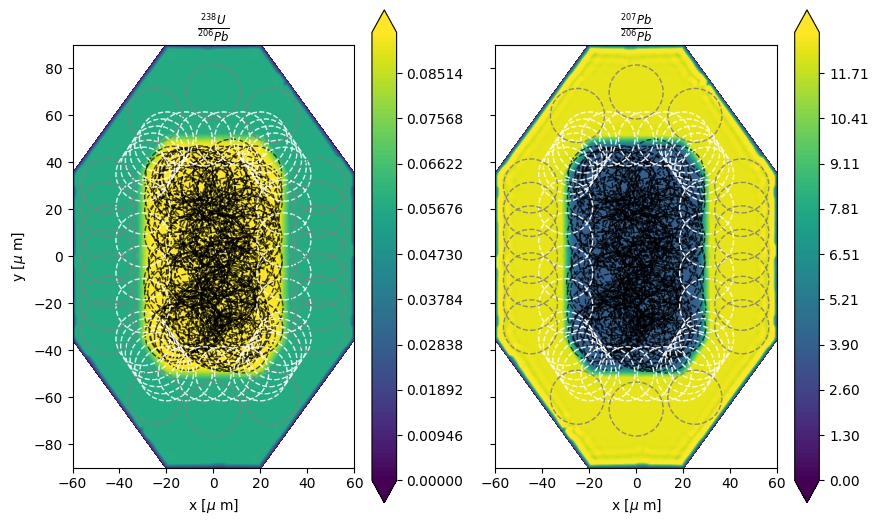

In [51]:
if save_figs:
    import matplotlib.pyplot as plt
    import numpy as np
    data = np.load(f'{outputPath}/ratio_data.npz')['data']

    fig, ax = plt.subplots(1,2, figsize=(10, 8), sharey=True)
    
    contour1 = DIF.utilities.plot_mesh_data(data[:,0:2]*100, data[:,2], ax=ax[0], vmin=np.quantile(data[:,2], 0.05), vmax=np.quantile(data[:,2], 0.95), levels=100)
    contour2 = DIF.utilities.plot_mesh_data(data[:,0:2]*100, data[:,3], ax=ax[1], vmin=np.quantile(data[:,3], 0.05), vmax=np.quantile(data[:,3], 0.95), levels=100)

    for spot in sample_centre_points:
        DIF.utilities.plot_spot_sample(spot[0:2]*100, radius=23/2, ax=ax[0], alpha=0.7, linewidth=1.)
        DIF.utilities.plot_spot_sample(spot[0:2]*100, radius=23/2, ax=ax[1], alpha=0.7, linewidth=1.)

    for spot in zircon_interface_sample_locations:
        DIF.utilities.plot_spot_sample(spot[0:2]*100, radius=23/2, ax=ax[0],colour='white', alpha=0.9, linewidth=1.)
        DIF.utilities.plot_spot_sample(spot[0:2]*100, radius=23/2, ax=ax[1],colour='white', alpha=0.9, linewidth=1.)

    for spot in outer_zircon_sample_locations:
        DIF.utilities.plot_spot_sample(spot[0:2]*100, radius=23/2, ax=ax[0],colour='gray', alpha=0.9, linewidth=1.)
        DIF.utilities.plot_spot_sample(spot[0:2]*100, radius=23/2, ax=ax[1],colour='gray', alpha=0.9, linewidth=1.)
   
    for _ax in ax:

        _ax.set_xlabel(r'x [$\mu$ m]')
        _ax.set_aspect('equal')

        _ax.set_xlim(-60, 60)
        _ax.set_ylim(-90, 90)

    ax[0].set_ylabel(r'y [$\mu$ m]')



    ax[0].set_title(r'$\frac{^{238}U}{^{206}Pb}$')
    ax[1].set_title(r'$\frac{^{207}Pb}{^{206}Pb}$')

    plt.colorbar(contour1, ax=ax[0], shrink=0.8)
    plt.colorbar(contour2, ax=ax[1], shrink=0.8)

    contour1.set_edgecolors("face")
    contour2.set_edgecolors("face")

    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')

    plt.savefig(f'{outputPath}/zircon-U-Pb_isotope_ratio_mesh_plots.pdf', dpi=300)




#### Now we plot the Terra-Wasserburg plot to assess discordance

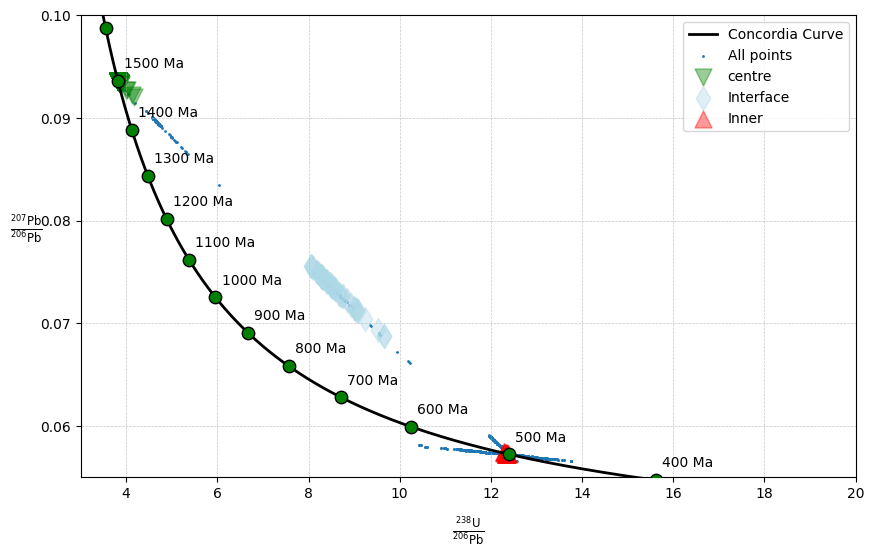

In [52]:
if save_figs:
    fig, ax = plt.subplots(figsize=(10,6))
    DIF.utilities.plot_terra_wasserburg_plot(start_time=2000e6, end_time=100e6, marker_spacing=100e6, ax=ax)
    
    ax.scatter(ratio_U23Pb8206[~np.isnan(ratio_U23Pb8206)], ratio_Pb207_Pb206[~np.isnan(ratio_Pb207_Pb206)], zorder=0, s=1, label='All points')
    
    ax.set_xlim(3, 20)
    ax.set_ylim(0.055, 0.10)
    
    ax.scatter(spot_data_centre[:,0], spot_data_centre[:,1], marker='v',c='green', s = 150, alpha=0.4, label='centre')
    
    ax.scatter(spot_data_interface[:,0], spot_data_interface[:,1], marker='d', c='lightblue', s = 150, alpha=0.4, label='Interface')
    
    ax.scatter(spot_data_outer[:,0], spot_data_outer[:,1], marker='^', c='red', s = 150, alpha=0.4, label='Inner')

    ax.set_ylabel(r'$\frac{^{207}\mathrm{Pb}}{^{206}\mathrm{Pb}}$', rotation=0, labelpad=10)
    ax.set_xlabel(r'$\frac{^{238}\mathrm{U}}{^{206}\mathrm{Pb}}$', rotation=0, labelpad=10)
    
    ax.legend(fontsize=10, loc="best", frameon=True)

    plt.savefig(f'{outputPath}/concordia_plot+spot_data.pdf', bbox_inches='tight')

    

----
Finally, we save the timing results and some stats from the model

In [53]:
time_end = time.time()

total_time = time_end - time_start

In [54]:
if uw.mpi.rank == 0:
    import pandas as pd

    # --- File 1: Data in columns (standard CSV) ---
    timing_data = timing.get_data()
    rows = []
    for (location, idx), (count, time) in timing_data.items():
        rows.append({
            'Location': location,
            'Index': idx,
            'Count': count,
            'Time': time,
            'Average': time/count,
        })
    df = pd.DataFrame(rows)
    df.sort_values(by='Average', inplace=True, ascending=False)
    df.to_csv(f'{outputPath}/Diffusion_results_columns.csv', index=False)

    # --- File 2: Data in rows (single row, best for summary) ---
    summary = {
        'U_degree': U_degree,
        'n_unknowns': U238_Pb206.daughter_mesh_var.coords.shape[0],
        'MinRadius': U238_Pb206.mesh.get_min_radius(),
        # 'Pb_L2_norm': Pb_l2_norm,
        # 'U_L2_norm' : U_l2_norm,
        'CFL_fac' : CFL_fac,
        'TotalTime': total_time,
        'NumProcessors': uw.mpi.size,
    }
    # Save as a single row (header + values)
    with open(f'{outputPath}/Diffusion_results_rows.csv', 'w') as f:
        f.write(','.join(summary.keys()) + '\n')
        f.write(','.join(str(v) for v in summary.values()) + '\n')